# Bayesian Statistical Inference
### Data Analysis in Astronomy / Physics
#### António Cesário, 201706207
#### Master's in Experimental Physics, FCUP

In [32]:
library('ggplot2')
library('pracma')
library('pryr')

#object_size(matrix(rnorm(101*101)**2,nrow=101))
memuse::Sys.meminfo()
# library("cubature")

Totalram:  7.864 GiB 
Freeram:   4.102 GiB 

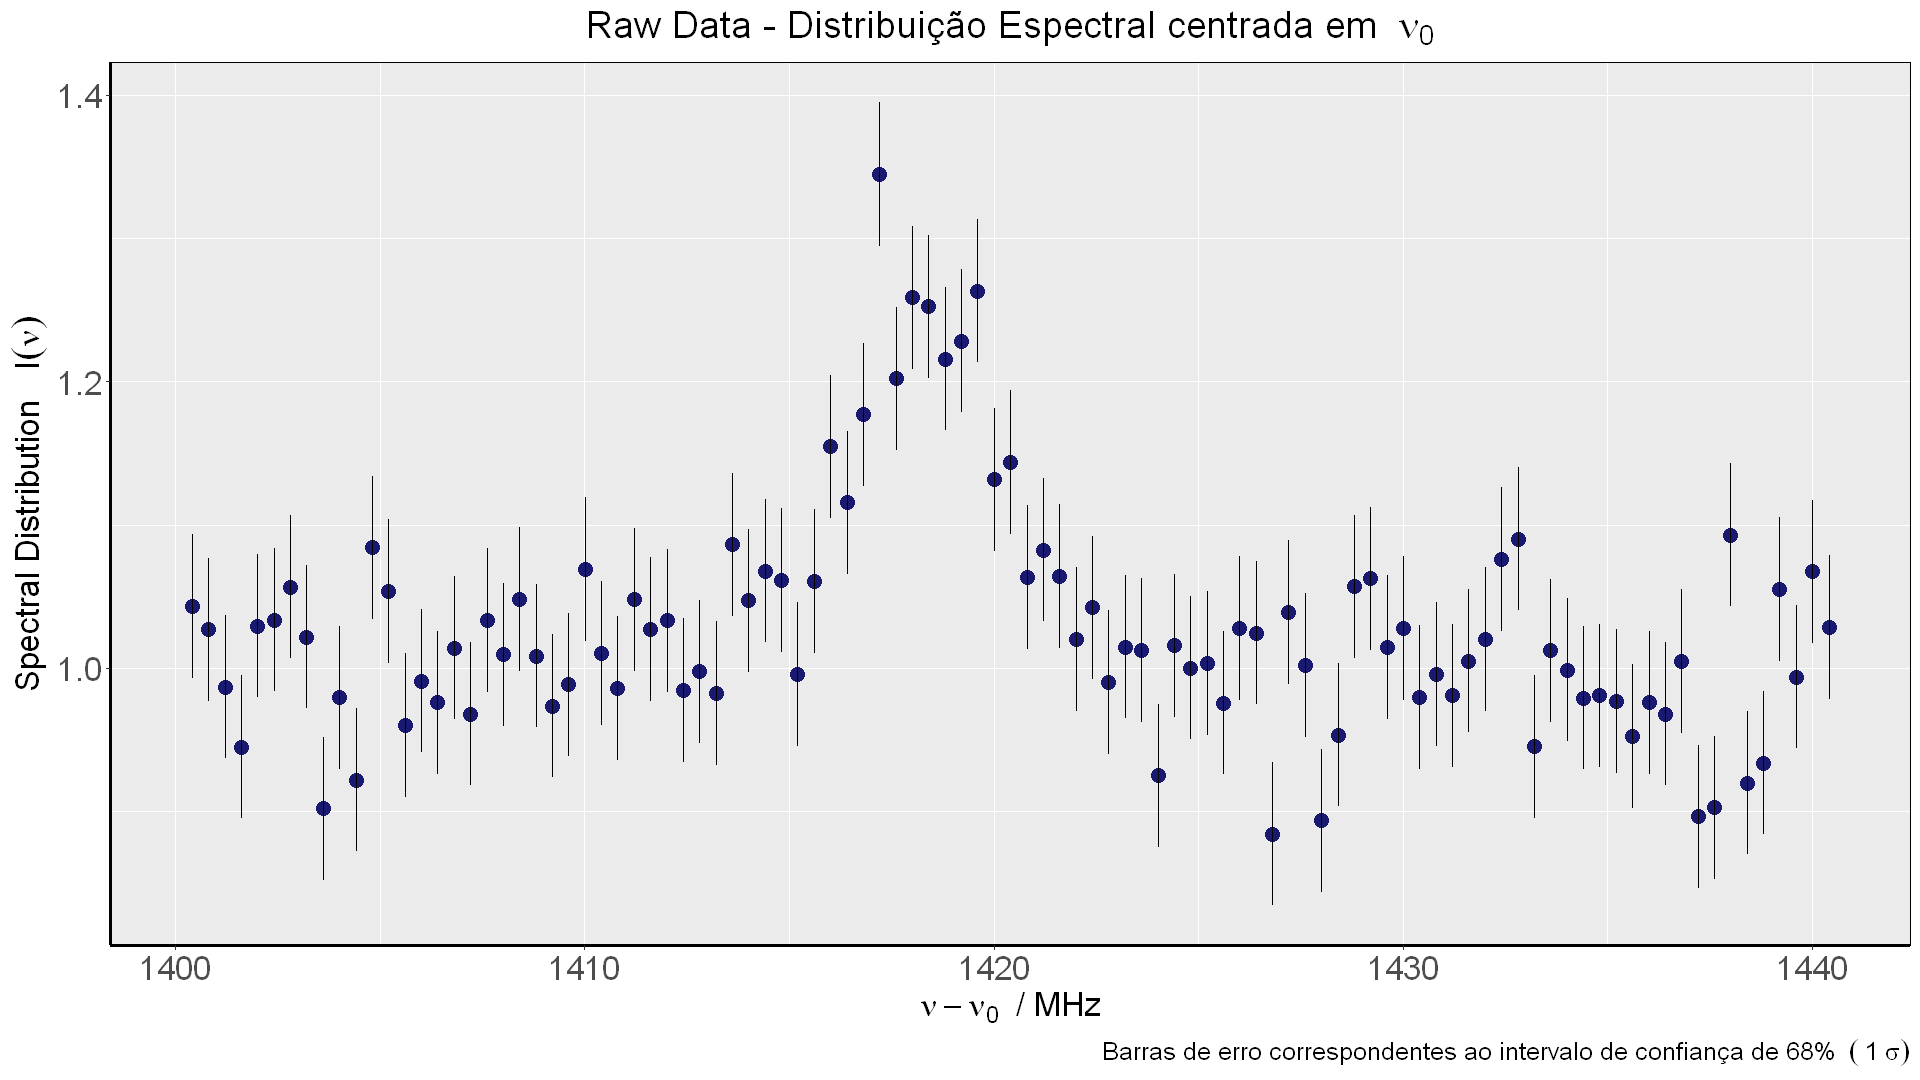

In [33]:
# Raw data visualization
options(repr.plot.width=16, repr.plot.height=9)
dados <- read.csv(file = 'data_Antonio.R',sep=' ', header=FALSE)
names(dados) = c('freq','intensity') # change data.frame header's names
# plot( dados,
#       main = expression(paste('Raw Data - Distribuição Espectral centrada em ',nu[0])),
#       xlab = expression(paste(nu-nu[0],' / MHz')),
#       ylab = expression(paste('Spectral Distribution\t',  I(nu) ))
#       )

# ggplot theme to ease visualization in jupyter notebook documents
jupyter.theme <- function(base_size = 13, base_family = "", base_line_size = base_size/22, 
                         base_rect_size = base_size/22) {         
  theme( 
    plot.title = element_text(size=23,hjust = 0.5),
    axis.title = element_text(size = 20),                               
    axis.text.x = element_text(size = 20),                              
    axis.text.y = element_text(size = 20),                              
    plot.caption = element_text(size = 15, face = "italic"),            
    #panel.background = element_rect(fill="white"),                      
    axis.line = element_line(size = 1, colour = "black"),
    strip.background = element_rect(fill = "#cddcdd"),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5),
        strip.text = element_text(colour = "black"),
        legend.key=element_blank()
  )
}

# actual plotting
ggplot( aes(x = freq, y = intensity), data = dados) +
    geom_point( size = 4 , colour = 'midnightblue' ) +
    xlab(bquote(nu-nu[0]~' / MHz')) +
    ylab(bquote('Spectral Distribution\t' ~ I(nu))) +
    labs(title = bquote('Raw Data - Distribuição Espectral centrada em '~nu[0]),
        caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma))) + 
    geom_linerange(aes(ymin = intensity -.05, ymax = intensity + .05)) + 
    jupyter.theme()

### $\mathcal{A}.2$ Cálculo de $p\left(g\mid G^+,D,I\right)$

$$
p\left(g \mid G^{+}, D, I\right) = \dfrac{p\left(g \mid G^+ , I\right)}{p\left(D \mid G^{+} ,I\right)} p\left( D \mid g , G^+, I\right)
$$

$$
\begin{align}
p\left( D \mid g , G^+, I\right) &\equiv \textrm{Likelihood de assumindo $g$ }\\
p\left(D \mid G^{+} ,I\right) &\equiv \textrm{Likelihood marginal/global (evidência) }\\
p\left(g \mid G^+ , I\right) &\equiv \textrm{Probabilidade prévia (prior)}
\end{align}
$$

## A. Question A

Queremos avaliar a existência de uma risca espectral na gama de frequências analisada experimentalmente. Para isso, foi proposta uma teoria em que a emissão é caracterizada pela seguinte equação

$$
\begin{align}
G(\nu) &= 1 \pm \frac{1}{g} \sqrt{\frac{\ln 2}{\pi}} \operatorname{exp}\left\{-\dfrac{\log 2\left(\nu-\nu_{0}\right)^{2}}{g^{2}}\right\}\\
+ &\equiv \textrm{a risca é de emissão}\\
- &\equiv \textrm{a risca é de absorção}
\end{align}
$$

onde $\nu_0$ (posição central do pico) e $g$ (1/2 da **FWHM**) são parâmetros livres da teoria. Propõem-se, portanto, os modelos 

$$
\begin{align}
G^0 &\equiv \textrm{distribuição uniforme na gama de frequências apresentada.}\\
G^+ &\equiv \textrm{emissão espectral caracterizada por $\nu_0$ e $g$.}
\end{align}
$$

Para testar qual destes modelos descreve melhor os dados obtidos, irei recorrer a uma análise Bayesiana dos mesmos, onde primeiro irei determinar o *Odds Ratio* entre os modelos $G_0$ e $G^+$ assumindo $g=2$, ao qual irei chamar

$$
G_2^+ \equiv \textrm{emissão espectral caracterizada por $\nu_0$ com $g=2$.}
$$

que apresenta apenas um parâmetro livre, a posição da risca espectral $\nu_0$.

### A.1 Cálculo de $\mathcal{O}_{0}^{2+}$

O *Odds Ratio* entre os modelos $G_2^+$ e $G^0$ é dado por

$$
\begin{aligned}
\mathcal{O}_{0}^{2+} &= \dfrac{p\left(G_2^{+} \mid D, I\right)}{p\left(G^{0} \mid D, I\right)} \\
&=\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid I\right)} \cdot \dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)}
\end{aligned}
$$

onde identificamos os termos

$$
\begin{aligned}
\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid \mathrm{I}\right)} &\equiv \textrm{razão entre priors}\\
\dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)} &\equiv \textrm{fator de Bayes}
\end{aligned}
$$

assumindo ignorância total sobre qual dos modelos caracteriza melhor os dados,

$$
\dfrac{p\left(G_2^{+} \mid I\right)}{p\left(G^{0} \mid I\right)} = 1
$$

logo

$$
\mathcal{O}_{0}^{2+} = \dfrac{p\left(D \mid G_2^{+}, I\right)}{p\left(D \mid G^0, I\right)} \quad \textrm{(fator de Bayes)}
$$

Se $\mathcal{O}_{0}^{2+} >> 1$ o modelo $G^+$ descreve os dados com maior verossemelhança. O oposto caso $\mathcal{O}_{0}^{2+} << 1$. O método para calcular os termos acima será apresentado mais adiante, na discussão da determinação da probabilidade pedida.

### A.2 Cálculo de $p\left( D \mid \nu_0 , G_2^+, I\right)$ - ( *Likelihood* do modelo $G_2^+$ assumindo $\nu_0$)

Admitindo que os resultados de cada medição são **independentes**, a probabilidade de obter os dados da experiência assumindo o modelo $G^+$ com $\nu_0 = \nu_0$ é dada por

$$
\begin{align}
p\left(D \mid G_2^{+}, \nu_{0}, I\right) &= \prod_{i=1}^{N} p\left(D_{i} \mid G_2^{+}, \nu_{0}, I\right)\\
    &= \prod_{i=1}^{N} p\left(E_{i} \mid G^{+}, \nu_{0}, I\right)
\end{align}
$$

$$
\begin{align}
p\left(D_{i} \mid G_2^{+}, \nu_{0}, I\right) &\equiv \textrm{probabilidade de obter o valor $d_i$ na medição $i$ de acordo com o modelo $G_2^{+}$ }\\
p\left(E_{i} \mid G_2^{+}, \nu_{0}, I\right) &\equiv \textrm{probabilidade de obter um erro de $e_i$ na medição $i$ de acordo com o modelo $G_2^{+}$ }
\end{align}
$$

O valor medido no bin $i$, $d_i$, é, à luz do modelo $G_2^+$, dado por

$$
\begin{align}
d_i &= f_i + e_i\\
f_i &= 1 + \frac{1}{g} \sqrt{\frac{\log 2}{\pi}} \operatorname{exp}\left\{-\dfrac{\log 2\left(\nu-\nu_{0}\right)^{2}}{g^{2}}\right\}
\end{align}
$$

onde $f_i$ é o valor previsto pelo modelo e $e_i$ o erro da medição. É-nos dito que o erro tem forma Gaussiana com um desvio padrão de $\sigma = 0.05 \textrm{ MHz}$ logo podemos escrever

$$
\begin{align}
p\left(E_{i} \mid G_2^{+}, \nu_{0}, I\right) &= \frac{1}{\sigma \sqrt{2 \pi}} \operatorname{exp}\left\{-\dfrac{e_{i}^{2}}{2 \sigma^{2}}\right\}\\
&= \dfrac{1}{\sigma \sqrt{2 \pi}} \operatorname{exp}\left\{-\dfrac{\left(d_i-f_i\right)^{2}}{2 \sigma^{2}}\right\}
\end{align}
$$

concluimos, portanto, que

$$
p\left(D \mid G_2^{+},\nu_0, I\right)=\frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
$$

onde, mais uma vez, $d_i$ é o valor obtido no bin $i$ e $f_i$ o valor previsto pelo modelo $G_2^+$ para esse mesmo bin.

Para determinar a Likelihood global do modelo $G_2^+$, ***Marginal Likelihood***, precisamos de marginalizar a *Likelihood* acima nos seus parâmetros livres, neste caso em $\nu_0$. Voltaremos a este ponto depois de determinar a Likelihood de $G^0$.

#### A.2.1 Cálculo de $p\left( D \mid G^0, I\right)$ - (*Likelihood* do modelo $G^0$)

O modelo $G^0$ assume que o espectro obtido experimentalmente deve de ser constante $(=1)$ e não tem parâmetros livres. Assim, usando a mesma argumentação que na derivação da *Likelihood* anterior,

$$
d_i = 1 + e_i
$$

e portanto

$$
p\left(D \mid G^{0}, I\right)=\frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-1\right)^{2}\right\}
$$

### A.3 Cálculo de $p\left(D \mid G_2^{+}, I\right)$ - ( Likelihood Marginal de $G_2^+$ )

A *Likelihood* que queremos determinar nesta secção é dada por

$$
p\left(D \mid G_2^{+}, I\right)
    = \int \operatorname{d\nu_0} p \left(\nu_0 \mid G_2^{+}, I \right) p\left(D \mid \nu_0,G_2^{+}, I\right)\\
$$

#### A.3.1 Escolher $p \left(\nu_0 \mid G_2^{+}, I \right)$ - ( *prior* de $\nu_0$)

Para escolher a ***prior*** de $\nu_0$, $p \left(\nu_0 \mid G_2^{+}, I \right)$, primeiro reconhecemos que este termo se trata de um **parâmetro de localização** da distribuição, pelo que será aconselhado escolher

$$
p \left(\nu_0 \mid G_2^{+}, I \right) = \dfrac{1}{\Delta\nu}
$$

para impôr a condição da invariância de translação neste parâmetro. Como só nos é fornecida informação relativamente à gama de frequências estudada experimentalmente, irei assumir que o pico de emissão existe nesta mesma gama de frequências, ou seja,

$$
\begin{align}
\Delta \nu 
    &= \nu_{\textrm{Máximo medido}} - \nu_{\textrm{mínimo medido}}\\
    &= 1440.4 - 1400.4\\
    &= 40 \textrm{ MHz}
\end{align}
$$

Para além da invariância de translação, outra razão que me levou a escolher uma *prior* uniforme para este parâmetro, em vez de uma de Jeffreys, está relacionada com o facto de $\Delta\nu$ não se estender por várias ordens de grandeza, pelo contrário,

$$
\dfrac{\Delta\nu}{\nu_{min}} \approx 3 \%
$$

o que significa que o acréscimo de probabilidade para maiores valores de $\nu_0$ devido à *prior* uniforme será pequeno.
Com isto concluimos que 

$$
p\left(D \mid G_2^{+}, I\right)
    = \int \dfrac{\operatorname{d\nu_0}}{\Delta\nu} \frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
$$

Com isto, estão estabelecidas as equações principais necessárias para realizar a análise de dados das alíneas A e B propostas. A discussão que se segue irá centrar-se mais no código e nos algoritmos utilizados para a concretização da análise.

### A.4 Determinar $p\left(D\mid G^+,I\right)$ - (*Likelihood* do modelo $G^+$)

Finalmente, para determinar a *Likelihood* global associada ao modelo $G^+$, temos que marginalizar $p\left(D\mid g, G^+,I\right)$ no parâmetro $g$, ou seja,

$$
\begin{align}
p\left(D \mid G^{+}, I\right)
    &= \int \operatorname{dg} p \left(g \mid G^{+}, I \right) p\left(D \mid g,G^{+}, I\right)\\
    &= \int \dfrac{\operatorname{dg}}{4\log\left(10\right)\cdot g}\left[
    \int \dfrac{\operatorname{d\nu_0}}{\Delta\nu} \frac{1}{\sigma^{N}(2 \pi)^{N / 2}} \exp\left\{-\frac{1}{2 \sigma^{2}} \sum_{i=1}^{N}\left(d_{i}-f_{i}\right)^{2}\right\}
    \right]
\end{align}
$$

Com isto, estão estabelecidas as equações principais necessárias para realizar a análise de dados desta questão. A discussão que se segue irá centrar-se mais no código e nos algoritmos utilizados para a concretização da análise.

In [34]:
# Defining Constants trhoughout the question
Nu.data <- dados[1]
G.data <- dados[2]

sigma <- 0.05
N <- 101

nu.min <- Nu.data$freq[1] # minimum value of \nu in data
nu.max <- tail(Nu.data$freq,n=1) # maximum of \nu in data
Delta.nu <- nu.max - nu.min # range of frequencies in data

g.max <- 1e+2
g.min <- 1e-2


# Likelihood - G0 hypothesis - Final Calculation
Likelihood_G.null <- function(){
    summation <- sum( (G.data - 1.)^2. ) * (- 0.5 / sigma^2. )
    
    exp(summation) / ( sqrt(2.*pi) * sigma ) ^ N
}

# Theoretical Emission Curve - G+ hypothesis 
emission_spec <- function(nu_0, g) {
    # nu_0 : free parameter, postion of the emission spectrum
    # g : free parameter, scale of the emission spectrum
    f1 <- exp( - log(2) * (Nu.data-nu_0)^2 / g^2 )
    1. + f1 * sqrt(log(2)/pi) / g
}

# Likelihood Function - Integral in \nu_0 Calculation
integrand_Likelihood_G.2plus <- function(nu_0,g=2){
    fi <- emission_spec( nu_0 , g )
    summation  <- sum( (G.data - fi)^2. ) * (- 0.5 / sigma^2.0 )
    
    exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# # Marginal Likelihood - G2+ hypothesis - Integral Calculation
Likelihood_G.2plus <- function(){
    
    integrate(Vectorize(integrand_Likelihood_G.2plus ,vectorize.args='nu_0'),
             lower = nu.min,
             upper = nu.max,
             g = 2,
             rel.tol = 1e-4) # rel.tol = relative total numerical error of integration
}

# Marginal Likelihood - G+ hypothesis - Double Integral Calculation
Likelihood_G.plus <- function(){
    
    integral2(Vectorize(function(g,nu_0){
        
        1 / ( Delta.nu * ( g * log(g.max/g.min) ) * ( sqrt(2*pi) * sigma ) ^ N ) * # 1 / (...) * \\ exp(...)

        exp(sum(( G.data - 1 - exp(-log(2)*(Nu.data-nu_0)^2/g^2) * sqrt(log(2)/pi)/g) ^2) * (- 0.5 / sigma^2 )) 

        }), xmin=g.min, xmax=g.max, ymin=nu.min, ymax=nu.max)
    }

### $\mathcal{A}$ Cálculo de $\mathcal{O}_{0}^{2+}$
Na célula acima estão implementadas as rotinas principais necessárias para avaliar as quantidades necessárias para o resto da alínea A.


In [35]:
# A.1 Odds Ratio
# (cell runtime: < 4s)
L.G0 = Likelihood_G.null()
L.G2p = Likelihood_G.2plus()

In [36]:
odds_ratio = format( L.G2p$value / L.G0 , scientific = TRUE , digits = 5 )
num_error = format( L.G2p$abs.error / L.G2p$value * 100 , scientific = TRUE , digits = 1 )

cat('Odds Ratio = ', odds_ratio)
cat('\nwith a numerical error of', num_error,'%')

Odds Ratio =  4.5916e+45
with a numerical error of 2e-03 %

## B. Question B

Da célula anterior, concluimos com segurança que o modelo $G_2^+$ descreve os dados obtidos com muita maior verossemelhança que $G^0$. Estamos agora em condições de determinar a **probabilidade posterior** de cada $\nu_0$ à luz de $G_2^+$ tendo em conta os dados, ou seja, podemos determinar a *pdf (probability density function)* de $\nu_0$, que iremos usar para fazer a análise estatística do modelo escolhido.

$$
p\left(\nu_0 \mid G_2^{+}, D, I\right) = \dfrac{p\left(\nu_0 \mid G_2^+ , I\right)}{p\left(D \mid G_2^{+} ,I\right)} p\left( D \mid \nu_0, G_2^+, I\right)
$$

$$
\begin{align}
p\left(\nu_0 \mid G_2^{+}, D, I\right) &\equiv \textrm{Probabilidade posterior}\\
p\left( D \mid \nu_0, G_2^+, I\right) &\equiv \textrm{Likelihood de assumindo $\nu_0$ }\\
p\left(D \mid G_2^{+} ,I\right) &\equiv \textrm{Likelihood marginal/global (evidência) }\\
p\left(\nu_0 \mid G_2^+ , I\right) &\equiv \textrm{Probabilidade prévia (prior)}
\end{align}
$$

In [37]:
print('Checking if the functions are working properly')
nu0 = nu.min + Delta.nu/2

G2p.marginal = L.G2p$value
G2p.prior = 1 / Delta.nu
G2p.likelihood = integrand_Likelihood_G.2plus(nu0) * Delta.nu

G2p.posterior = G2p.prior * (G2p.likelihood/G2p.marginal)

G2p.posterior

[1] "Checking if the functions are working properly"


[1] 8.803242e-27

O próximo passo será representar graficamente a *pdf* obtida. Pretendo avaliar a função para cada frequência nos dados, ou seja, $\vec{\nu_0}$ tomará todas as frequências dos dados. Para vetorizar o cálculo de $p\left(\nu_0 \mid G_2^{+}, D, I\right)$, construí uma matriz $101\times101$ que contém as diferenças $\nu_i - \nu_0$ onde ao longo das linhas temos $\nu_0$ constante e $\nu$ ao longo das colunas. Isto pode ser facilmente conseguido com o código abaixo.

In [38]:
# Example of pdf vectorization

x = c(1:10) # array with all the \nu (data)
y = c(1:10) # array with all the \nu_0 wehere we want to determine the pdf

cat('x : ',x,'\n')
cat('y : ',y,'\n\n')

Mx = matrix( rep(x,each=10) ,nrow=10 ) # create a matrix of N stacked x arrays ( N = length(y))
cat('Matrix 10x10 - x stacked ',' ')
Mx

Mx = sweep(Mx, MARGIN = 1, y, "-") # subtract y to each column of Mx (MARGIN = 1 says it's the columns that we want to operate)
cat('\n\nMatrix 10x10 - after subtraction',' ')
Mx

rowSums(Mx) # We can also sum the values over every row, which will come in handy in a bit

x :  1 2 3 4 5 6 7 8 9 10 
y :  1 2 3 4 5 6 7 8 9 10 

Matrix 10x10 - x stacked   

1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10
1,2,3,4,5,6,7,8,9,10




Matrix 10x10 - after subtraction  

0,1,2,3,4,5,6,7,8,9
-1,0,1,2,3,4,5,6,7,8
-2,-1,0,1,2,3,4,5,6,7
-3,-2,-1,0,1,2,3,4,5,6
-4,-3,-2,-1,0,1,2,3,4,5
-5,-4,-3,-2,-1,0,1,2,3,4
-6,-5,-4,-3,-2,-1,0,1,2,3
-7,-6,-5,-4,-3,-2,-1,0,1,2
-8,-7,-6,-5,-4,-3,-2,-1,0,1
-9,-8,-7,-6,-5,-4,-3,-2,-1,0


[1]  45  35  25  15   5  -5 -15 -25 -35 -45

In [50]:
# Likelihood calculation for every value of \nu_0
x  = Nu.data$freq
Nu.diffs = matrix(rep(x,each=101),nrow=101)
Nu.diffs = sweep(Nu.diffs, MARGIN = 1,x, "-")

G.data_matrix = matrix(rep(G.data$intensity,each=101),nrow=101)

# Theoretical Emission Curve - G+ hypothesis 
G.predicted_matrix <- function() {
    g = 2
    
    1. + exp( - log(2) * Nu.diffs^2 / g^2 ) * sqrt(log(2)/pi) / g
}

# Likelihood Function - Integral in \nu_0 Calculation
Likelihood_G2p_matrix <- function(){
    
    summation  <- rowSums( (G.data_matrix - G.predicted_matrix() )^2. ) * (- 0.5 / sigma^2.0 )
    
    exp(summation) / Delta.nu / ( sqrt(2.*pi) * sigma ) ^ N
}

# Posterior Probability - G2+
posterior_G2p <- function(){
    G2p.prior * ( Likelihood_G2p_matrix() / G2p.marginal )
}


G2p.posterior = posterior_G2p()

In [66]:
df2 <- dados

nu0_moda = Nu.data$freq[which.max(G2p.posterior)]
emission_curve = emission_spec(nu0_moda,g=2)$freq

df2$nu0_moda <- emission_curve
colour = 
, colour = 

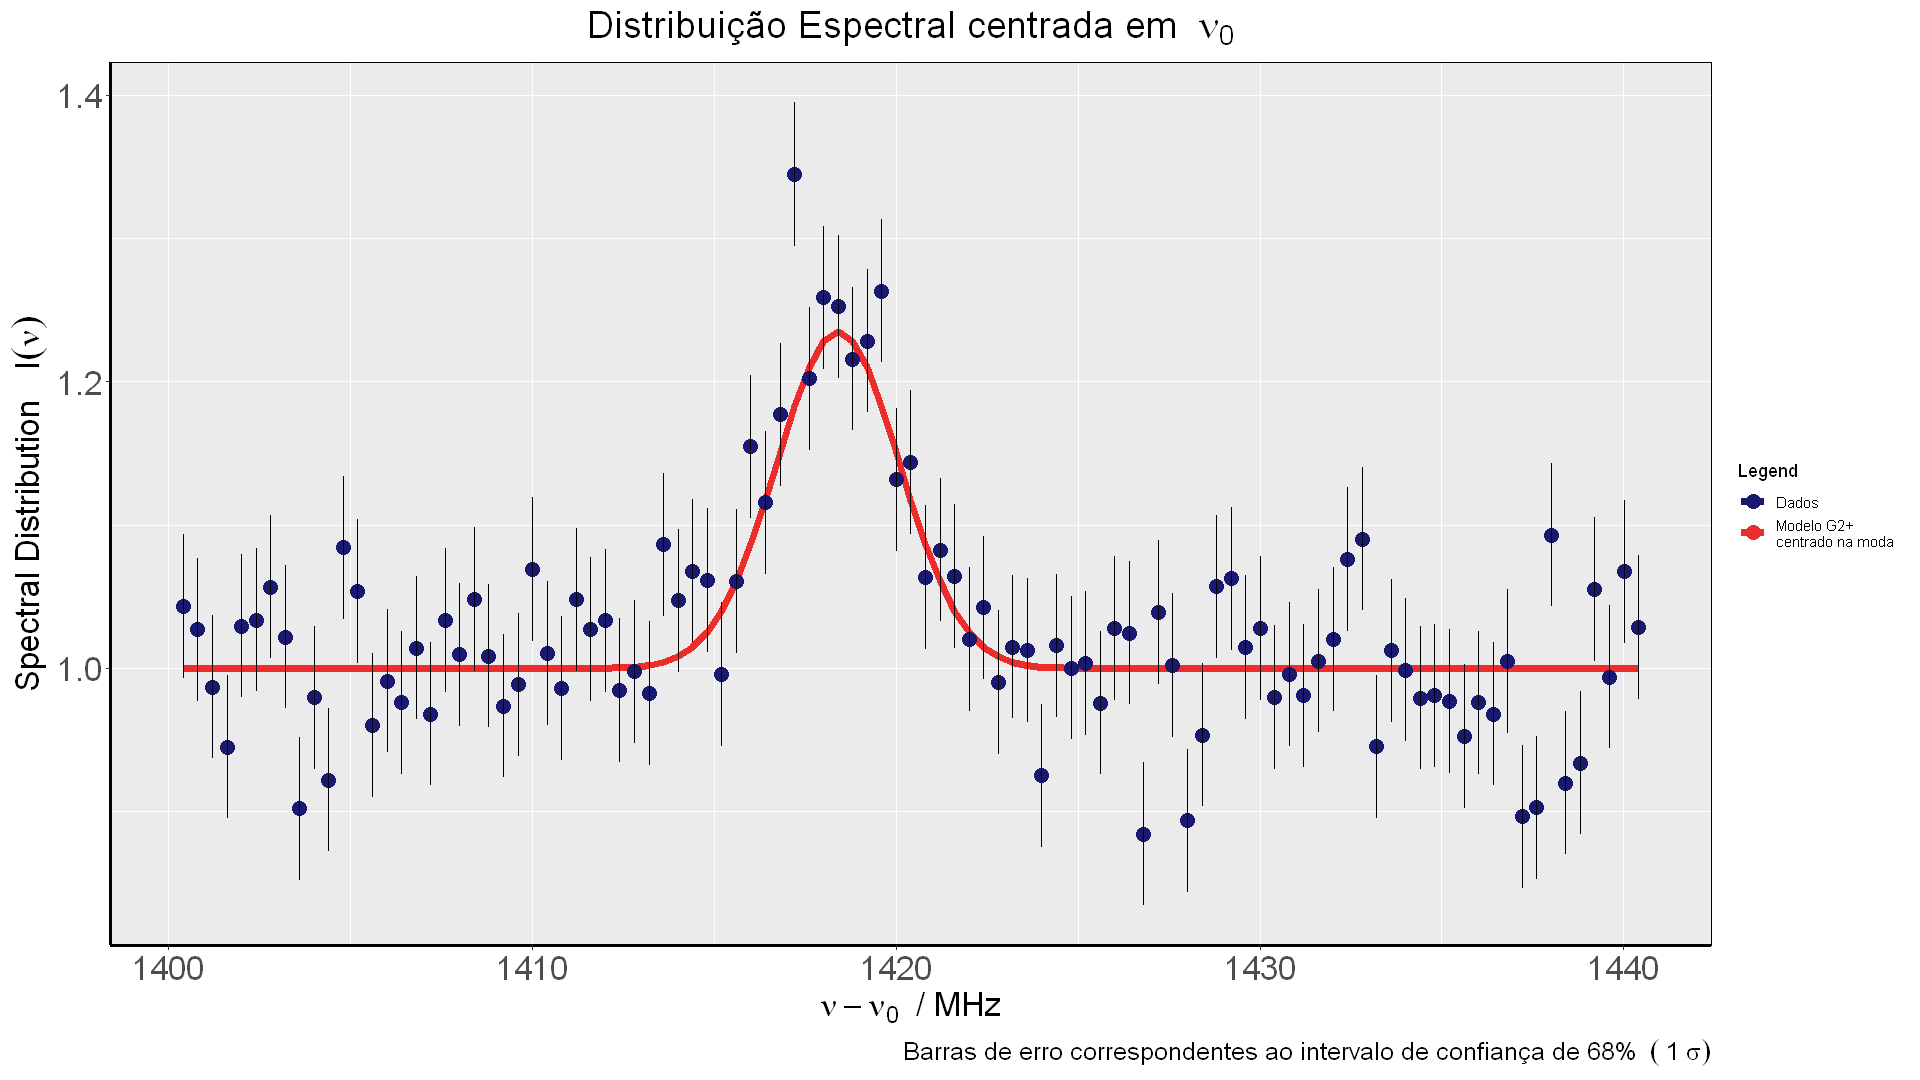

In [116]:
colors <- c("Dados" = 'midnightblue' , 'Modelo G2+\ncentrado na moda' = 'firebrick2')
ggplot(data = df2 , aes(freq) ) +

    geom_line(aes(y=nu0_moda,colour='Modelo G2+\ncentrado na moda') , size = 2 )+
    
    geom_point( aes(y=intensity,colour = 'Dados') , size = 4 ) +
    geom_linerange(aes(ymin = intensity -.05, ymax = intensity + .05),colour='black') + # error bars

    
    labs(title = bquote('Distribuição Espectral centrada em '~nu[0]),
         caption = bquote('Barras de erro correspondentes ao intervalo de confiança de 68% '~(~'1'~sigma)),
         x = bquote(nu-nu[0]~' / MHz'),
         y = bquote('Spectral Distribution\t' ~ I(nu)),
         colour = 'Legend') +

    scale_color_manual(values = colors) +
    
jupyter.theme()

In [88]:
?geom_line

In [41]:
# g.likelihood.array = Likelihood_given_g()
# g.likelihood = g.likelihood.array$value
# g.like.error = format(g.likelihood.array$abs.error / g.likelihood * 100,
#                       scientific = TRUE,
#                       digits = 3)
# g.likelihood
# g.like.error


# g.prior = g_prior(g=2)
# g.prior


# g.marginal.like = L.Gp$Q
# g.marginal.like

# g.posterior = ( g.likelihood / g.marginal.like ) * g.prior
# g.posterior

In [10]:
# Rcpp::cppFunction('double mylast(NumericVector x) { int n = x.size(); return x[n-1]; }')
# options(width=100)
# for (n in c(1e3,1e4)) {
#   x <- runif(n);
#   print(microbenchmark::microbenchmark(x[length(x)],
#                                        mylast(x),
#                                        tail(x, n=1),
#                                        dplyr::last(x),
#                                        x[end(x)[1]],
#                                        rev(x)[1]))}
#.Machine$double.eps^0.24

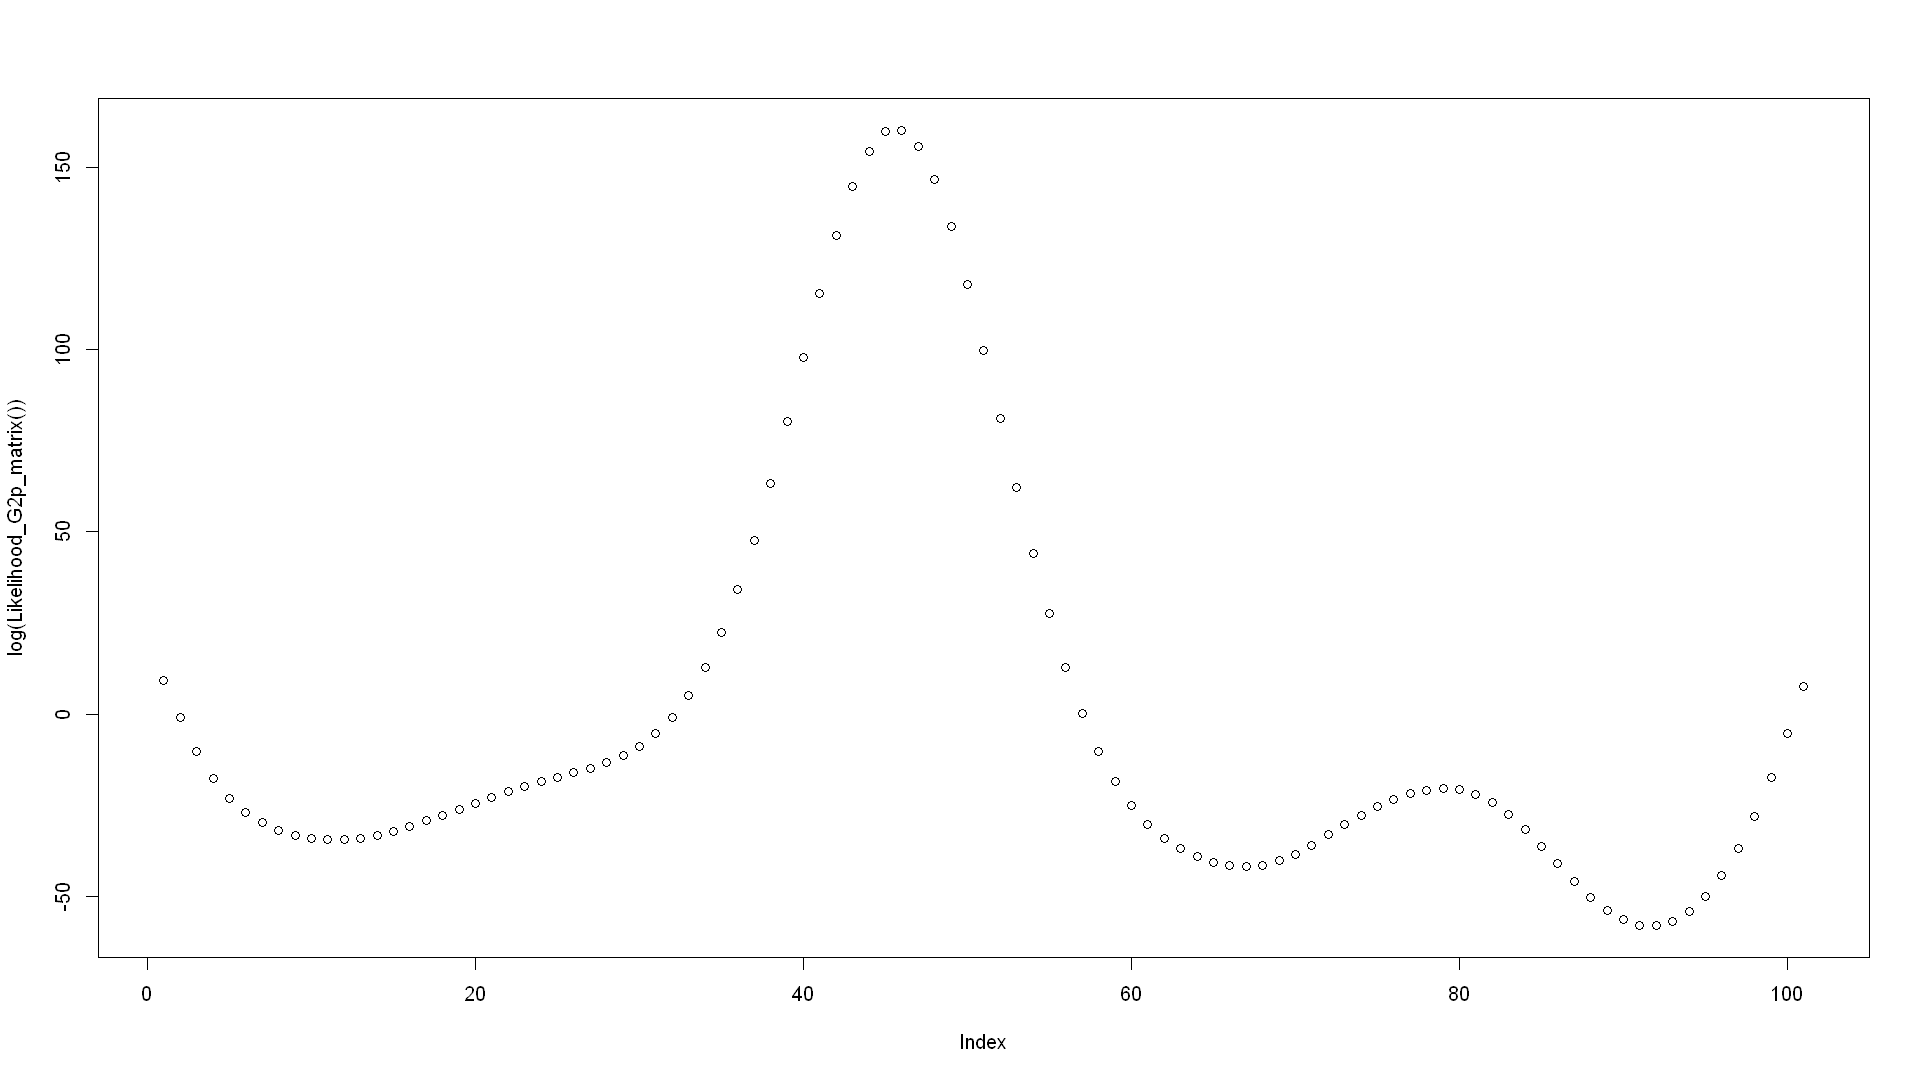